## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
tfds.disable_progress_bar()

## Prepare Dataset

We will first load in the data and split it so that we have an 80-20 split for the training and validation data.

In [4]:
ds_train = tf.keras.utils.image_dataset_from_directory("asl_alphabet_train", image_size=(200,200), seed=128, validation_split=0.2, subset="training")
ds_test = tf.keras.utils.image_dataset_from_directory("asl_alphabet_train", image_size=(200,200), seed=128, validation_split=0.2, subset="validation")

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


Now we will print out a portion of the data to confirm we have the data loaded correctly.

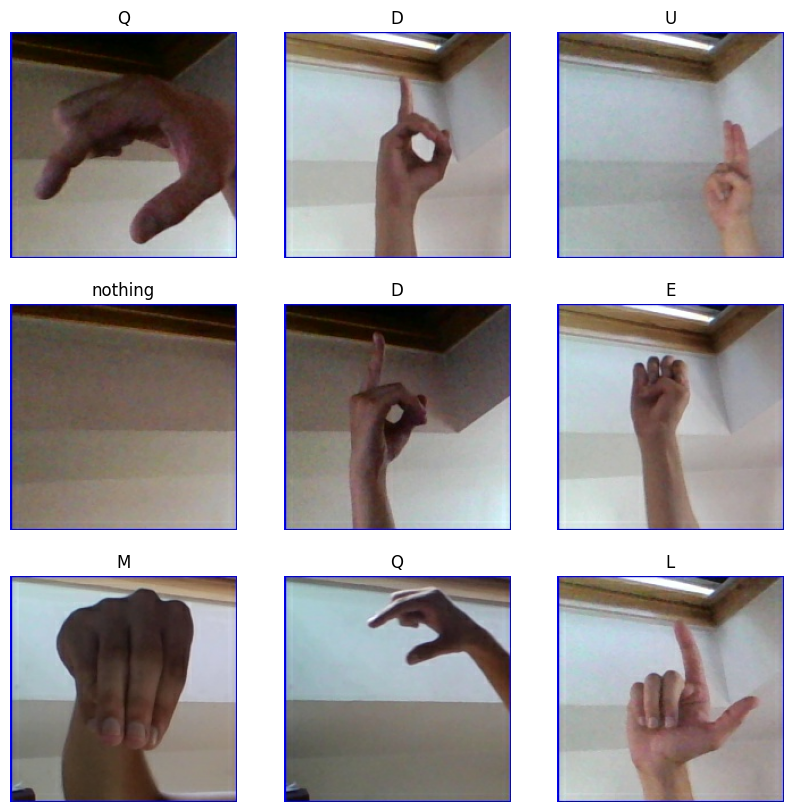

In [5]:
class_names = ds_train.class_names
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We will now convert the data into objects that tensor flow can use.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)
num_labels = len(class_names)

## Convolutional Neural Network

This is our simple neural network that we will use to test our implementation and get it running. This most recent run is using the GPU as we were later able to get that to work.

In [7]:
model = tf.keras.Sequential([
   tf.keras.layers.Rescaling(1./255),
   tf.keras.layers.AveragePooling2D(6,3, input_shape=(200,200,1)),
   tf.keras.layers.Conv2D(64, 3, activation='relu'),
   tf.keras.layers.Conv2D(32, 3, activation='relu'),
   tf.keras.layers.MaxPool2D(2,2),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Will TensorFlow, we simply can call `model.fit()` to train our model.

In [8]:
history = model.fit(ds_train, validation_data=ds_test, epochs=5, batch_size=32)

Epoch 1/5
2175/2175 [==============================] - 208s 88ms/step - loss: 0.9145 - accuracy: 0.7173 - val_loss: 0.2006 - val_accuracy: 0.9387
Epoch 2/5
2175/2175 [==============================] - 308s 142ms/step - loss: 0.2112 - accuracy: 0.9282 - val_loss: 0.0824 - val_accuracy: 0.9734
Epoch 3/5
2175/2175 [==============================] - 287s 132ms/step - loss: 0.1293 - accuracy: 0.9556 - val_loss: 0.0546 - val_accuracy: 0.9815
Epoch 4/5
2175/2175 [==============================] - 309s 142ms/step - loss: 0.0989 - accuracy: 0.9664 - val_loss: 0.0508 - val_accuracy: 0.9844
Epoch 5/5
2175/2175 [==============================] - 292s 134ms/step - loss: 0.0810 - accuracy: 0.9724 - val_loss: 0.0375 - val_accuracy: 0.9863


In case we lose the history of this run, it took 40 minutes to fit the model with the default layers we have. We did this with the CPU and that's why it took longer. Here is the data:

Epoch 1/5

2175/2175 [==============================] - 569s 253ms/step - loss: 1.0774 - accuracy: 0.6733 - val_loss: 0.3072 - val_accuracy: 0.9037

Epoch 2/5

2175/2175 [==============================] - 481s 221ms/step - loss: 0.2986 - accuracy: 0.9007 - val_loss: 0.1975 - val_accuracy: 0.9432

Epoch 3/5

2175/2175 [==============================] - 471s 217ms/step - loss: 0.1870 - accuracy: 0.9365 - val_loss: 0.0732 - val_accuracy: 0.9772

Epoch 4/5

2175/2175 [==============================] - 456s 210ms/step - loss: 0.1334 - accuracy: 0.9536 - val_loss: 0.0624 - val_accuracy: 0.9796

Epoch 5/5

2175/2175 [==============================] - 457s 210ms/step - loss: 0.1109 - accuracy: 0.9623 - val_loss: 0.0536 - val_accuracy: 0.9831

We will now save off the model so we don't have to take the time to run it again.

In [9]:
model.save("asl_trained_model")

INFO:tensorflow:Assets written to: asl_trained_model\assets


INFO:tensorflow:Assets written to: asl_trained_model\assets


Let's check out the summary of the model before we save it off so we can compare it.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 65, 65, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0

We will now load in the saved model and check that its summary matches above output. 

In [10]:
saved_model = tf.keras.models.load_model('asl_trained_model')

# Check its architecture
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 65, 65, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0

We can now create the validation set using the `asl_alphabet_test` directory.

In [11]:
ds_val = tf.keras.utils.image_dataset_from_directory("asl_alphabet_test", image_size=(200,200), seed=128, )

Found 28 files belonging to 28 classes.


When we run the `model.evaluate()` function, we can see that we are getting an accuracy of 92.86% and a loss of 3.2907.

In [12]:
# Evaluate the restored model
loss, acc = saved_model.evaluate(ds_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(saved_model.predict(ds_val).shape)

1/1 - 0s - loss: 3.2907 - accuracy: 0.9286 - 438ms/epoch - 438ms/step
Restored model, accuracy: 92.86%
1/1 [==============================] - 0s 201ms/step
(28, 29)


We can now take the `history` object that is made after running `model.fit()` and look at the training and validation accuracy for our model.

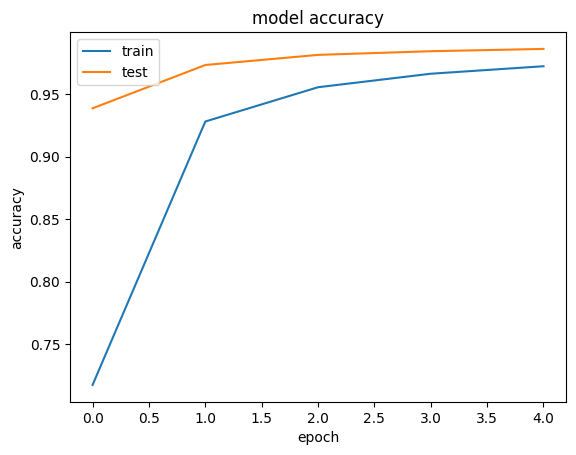

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./CNN_model_accuracy.png")
plt.show()

The history object also has training and validation loss information and so we can use that too. 

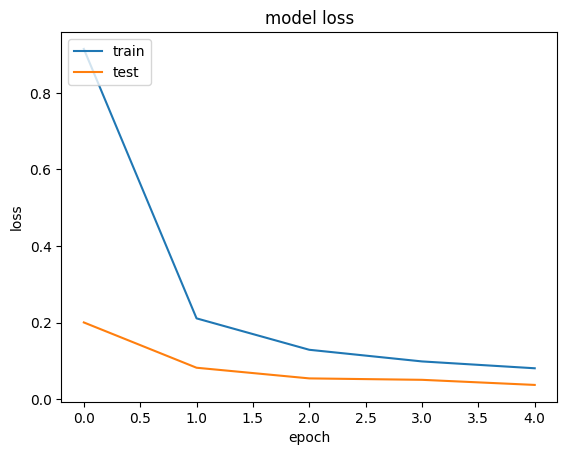

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./CNN_model_loss.png")
plt.show()

## AlexNet

The architecture of the following code is exactly the same as the CNN above, it's just augmented to work with AlexNet.

Reference: https://d2l.ai/chapter_convolutional-modern/alexnet.html

Preprocess Images: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [3]:
ds_train_alex = tf.keras.utils.image_dataset_from_directory("asl_alphabet_train", image_size=(227,227), seed=128, validation_split=0.2, subset="training")
ds_test_alex = tf.keras.utils.image_dataset_from_directory("asl_alphabet_train", image_size=(227,227), seed=128, validation_split=0.2, subset="validation")
num_labels = len(ds_train_alex.class_names) 
print("num labels", num_labels)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
num labels 29


In [6]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 200x200 to 277x277
    # image = tf.image.resize(image, (227,227))
    return image, label

In [4]:
for image_batch, labels_batch in ds_train_alex:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


In [7]:
ds_train_sz = tf.data.experimental.cardinality(ds_train_alex).numpy()
ds_test_sz = tf.data.experimental.cardinality(ds_test_alex).numpy()
print("ds train size", ds_train_sz)
print("ds test size", ds_test_sz)
ds_train_alex_batch = (ds_train_alex.map(process_images)
                    .shuffle(buffer_size=ds_train_sz)
                    .batch(batch_size=32, drop_remainder=True))
ds_test_alex_batch = (ds_test_alex.map(process_images)
                  .shuffle(buffer_size=ds_test_sz)
                  .batch(batch_size=32, drop_remainder=True))

print("train batch", ds_train_alex_batch)
print("test batch", ds_train_alex_batch)

ds train size 2175
ds test size 544
train batch <BatchDataset element_spec=(TensorSpec(shape=(32, None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, None), dtype=tf.int32, name=None))>
test batch <BatchDataset element_spec=(TensorSpec(shape=(32, None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, None), dtype=tf.int32, name=None))>


In [8]:

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1, 10000, 0.90, staircase=False,
)

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=lr,
#     weight_decay=0.0005
# )
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [9]:
history = model.fit(ds_train_alex, validation_data=ds_test_alex, epochs=5, batch_size=128)

Epoch 1/5
2175/2175 [==============================] - 374s 171ms/step - loss: 2.1343 - accuracy: 0.3909 - val_loss: 0.9095 - val_accuracy: 0.7655
Epoch 2/5
2175/2175 [==============================] - 374s 172ms/step - loss: 0.7677 - accuracy: 0.7502 - val_loss: 0.5399 - val_accuracy: 0.8299
Epoch 3/5
2175/2175 [==============================] - 371s 171ms/step - loss: 0.3700 - accuracy: 0.8800 - val_loss: 0.4114 - val_accuracy: 0.8639
Epoch 4/5
2175/2175 [==============================] - 379s 174ms/step - loss: 0.2037 - accuracy: 0.9345 - val_loss: 0.0904 - val_accuracy: 0.9763
Epoch 5/5
2175/2175 [==============================] - 385s 177ms/step - loss: 0.1166 - accuracy: 0.9629 - val_loss: 0.2258 - val_accuracy: 0.9256



Epoch 1/5

2175/2175 [==============================] - 358s 165ms/step - loss: 2.0213 - accuracy: 0.4116 - val_loss: 1.3568 - 
val_accuracy: 0.5951

Epoch 2/5

2175/2175 [==============================] - 366s 168ms/step - loss: 0.7357 - accuracy: 0.7619 - val_loss: 0.2748 - 
val_accuracy: 0.9274

Epoch 3/5

2175/2175 [==============================] - 366s 168ms/step - loss: 0.3420 - accuracy: 0.8887 - val_loss: 0.1338 - 
val_accuracy: 0.9647

Epoch 4/5

2175/2175 [==============================] - 363s 167ms/step - loss: 0.1876 - accuracy: 0.9402 - val_loss: 0.0597 - 
val_accuracy: 0.9893

Epoch 5/5

2175/2175 [==============================] - 363s 167ms/step - loss: 0.1177 - accuracy: 0.9635 - val_loss: 0.0751 - 
val_accuracy: 0.9744

In [10]:
model.save("Alex_Net_asl_trained_model")

INFO:tensorflow:Assets written to: Alex_Net_asl_trained_model\assets


INFO:tensorflow:Assets written to: Alex_Net_asl_trained_model\assets


In [11]:
saved_model = tf.keras.models.load_model('Alex_Net_asl_trained_model')

# Check its architecture
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [12]:
ds_val = tf.keras.utils.image_dataset_from_directory("asl_alphabet_test", image_size=(227, 227), seed=128, )

Found 28 files belonging to 28 classes.


In [13]:
# Evaluate the restored model
loss, acc = saved_model.evaluate(ds_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(saved_model.predict(ds_val).shape)

1/1 - 1s - loss: 1.2979 - accuracy: 0.9286 - 826ms/epoch - 826ms/step
Restored model, accuracy: 92.86%
1/1 [==============================] - 0s 477ms/step
(28, 29)


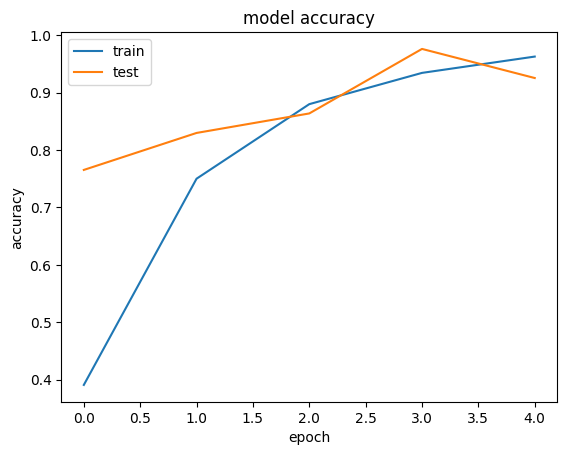

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./AlexNet_model_accuracy.png")
plt.show()

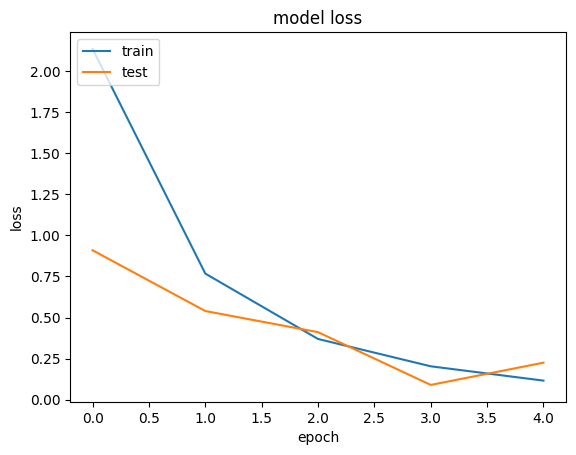

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./AlexNet_model_loss.png")
plt.show()

## ResNet

The architecture of the following code is exactly the same as the CNN above, it's just augmented to work with ResNet.

Reference: https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

In [7]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [8]:
# lr = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.1, 13050, 0.94, staircase=False,
# )

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=lr,
#     # weight_decay=0.0005
# )
# model = ResNet34((200,200,3), num_labels)
# model.compile(optimizer=optimizer,
#               loss=keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

model = ResNet34((200,200,3), num_labels)
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
history = model.fit(ds_train, validation_data=ds_test, epochs=5, batch_size=32)

Epoch 1/5
2175/2175 [==============================] - 1098s 494ms/step - loss: 1.1080 - accuracy: 0.6722 - val_loss: 0.2139 - val_accuracy: 0.9235
Epoch 2/5
2175/2175 [==============================] - 1207s 555ms/step - loss: 0.0941 - accuracy: 0.9688 - val_loss: 0.0901 - val_accuracy: 0.9697
Epoch 3/5
2175/2175 [==============================] - 1189s 546ms/step - loss: 0.0515 - accuracy: 0.9831 - val_loss: 0.1781 - val_accuracy: 0.9399
Epoch 4/5
2175/2175 [==============================] - 1148s 528ms/step - loss: 0.0398 - accuracy: 0.9885 - val_loss: 0.4649 - val_accuracy: 0.8844
Epoch 5/5
2175/2175 [==============================] - 1157s 532ms/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.0373 - val_accuracy: 0.9878



Epoch 1/5

2175/2175 [==============================] - 1098s 494ms/step - loss: 1.1080 - accuracy: 0.6722 - val_loss: 0.2139 - val_accuracy: 0.
9235

Epoch 2/5

2175/2175 [==============================] - 1207s 555ms/step - loss: 0.0941 - accuracy: 0.9688 - val_loss: 0.0901 - val_accuracy: 0.
9697

Epoch 3/5

2175/2175 [==============================] - 1189s 546ms/step - loss: 0.0515 - accuracy: 0.9831 - val_loss: 0.1781 - val_accuracy: 0.
9399

Epoch 4/5

2175/2175 [==============================] - 1148s 528ms/step - loss: 0.0398 - accuracy: 0.9885 - val_loss: 0.4649 - val_accuracy: 0.
8844

Epoch 5/5

2175/2175 [==============================] - 1157s 532ms/step - loss: 0.0296 - accuracy: 0.9911 - val_loss: 0.0373 - val_accuracy: 0.
9878

In [10]:
model.save("Res_Net_asl_trained_model")

INFO:tensorflow:Assets written to: Res_Net_asl_trained_model\assets


INFO:tensorflow:Assets written to: Res_Net_asl_trained_model\assets


In [11]:
ds_val = tf.keras.utils.image_dataset_from_directory("asl_alphabet_test", image_size=(200,200), seed=128, )

Found 28 files belonging to 28 classes.


In [12]:
saved_model = tf.keras.models.load_model('Res_Net_asl_trained_model')

# Check its architecture
saved_model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 103, 103, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [13]:
# Evaluate the restored model
loss, acc = saved_model.evaluate(ds_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(saved_model.predict(ds_val).shape)

1/1 - 1s - loss: 2.2747 - accuracy: 0.9286 - 1s/epoch - 1s/step
Restored model, accuracy: 92.86%
1/1 [==============================] - 1s 627ms/step
(28, 29)


In [16]:
print("history keys", history.history.keys())

history keys dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


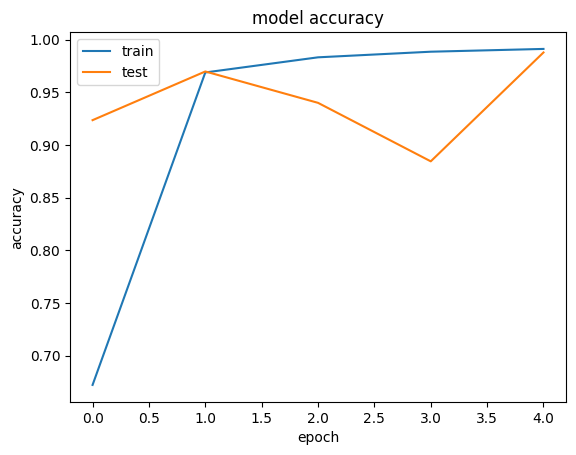

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./resnet_model_accuracy.png")
plt.show()

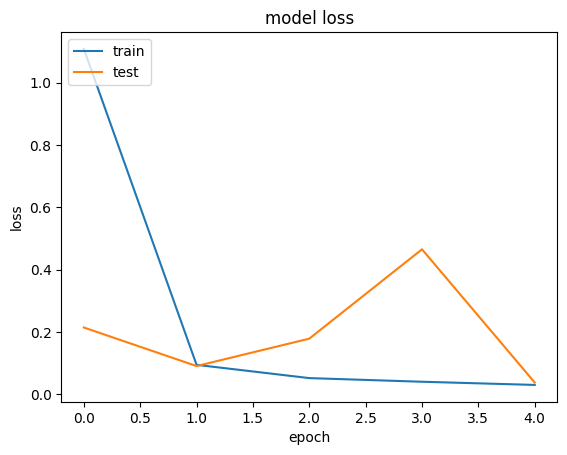

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./resnet_model_loss.png")
plt.show()